Library


In [1]:
import numpy as np
import math
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import optuna
from sklearn.model_selection import train_test_split

Konstanta


In [2]:
RANDOM_STATE = 21

# Dataset Inference


## Load


Dir


In [3]:
MAIN_PATH = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar"
# MAIN_PATH = 

Raw


In [4]:
with open(MAIN_PATH + r"\Dataset\dataset_preprocessed.pkl", "rb") as f:
    dataset = pickle.load(f)

In [5]:
len(dataset)

793

Normalisasi, Split, dan Batching


In [6]:
X = [[data[3], data[4]] for data in dataset]
original_labels = [int(data[2]) for data in dataset]
y = [1 if label in (0, 1) else 2 for label in original_labels]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE, stratify=y_test)

In [8]:
scl = StandardScaler()
X_train_scaled = scl.fit_transform(X_train)
X_test_scaled = scl.transform(X_test)
X_val_scaled = scl.transform(X_val)

## Analisa Statistik


In [9]:
t1 = 0
t2 = 0

for i in y:
    if i == 1:
        t1 += 1
    else:
        t2 += 1

print(t1, t2)

332 461


Describe


In [10]:
df_raw = pd.DataFrame(X, columns=['rms', 'zcr'])
df_raw['label'] = y

In [11]:
for label in df_raw['label'].unique():
    print(f"Label: {label}")
    display(df_raw[df_raw['label'] == label].describe().T)

Label: 2


,count,mean,std,min,25%,50%,75%,max
rms,461.0,0.024117,0.031788,0.0,0.002779,0.010696,0.032777,0.233416
zcr,461.0,5389.292842,4319.349303,0.0,1219.000000,5227.000000,9013.000000,14691.000000
label,461.0,2.000000,0.000000,2.0,2.000000,2.000000,2.000000,2.000000


Label: 1


,count,mean,std,min,25%,50%,75%,max
rms,332.0,0.094905,0.089512,0.003555,0.035525,0.070985,0.111692,0.448288
zcr,332.0,7773.786145,3544.973239,387.000000,5491.750000,8413.000000,10231.000000,14626.000000
label,332.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Visualization


<Axes: title={'center': 'rms'}, xlabel='label'>

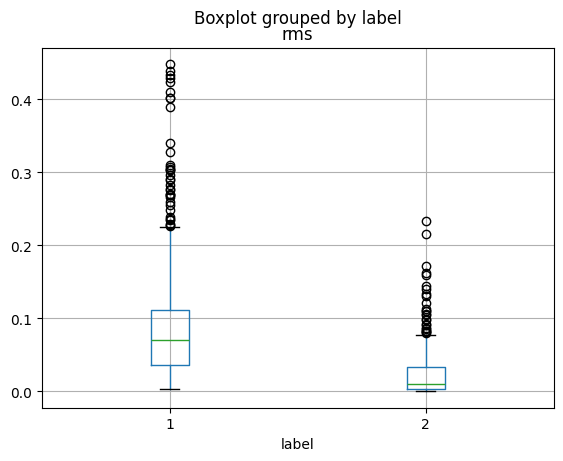

In [12]:
df_raw.boxplot(column=['rms'], by='label')

<Axes: title={'center': 'zcr'}, xlabel='label'>

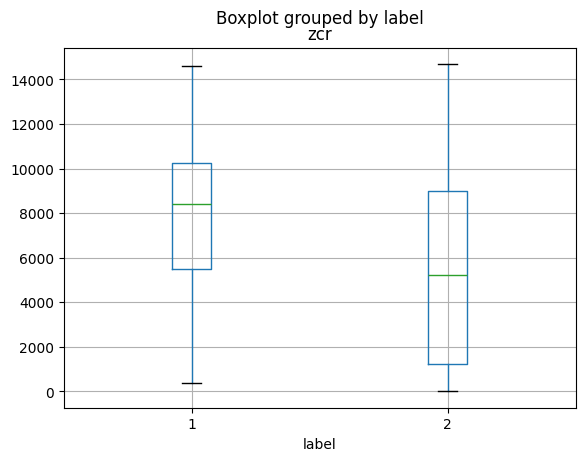

In [13]:
df_raw.boxplot(column=['zcr'], by='label')

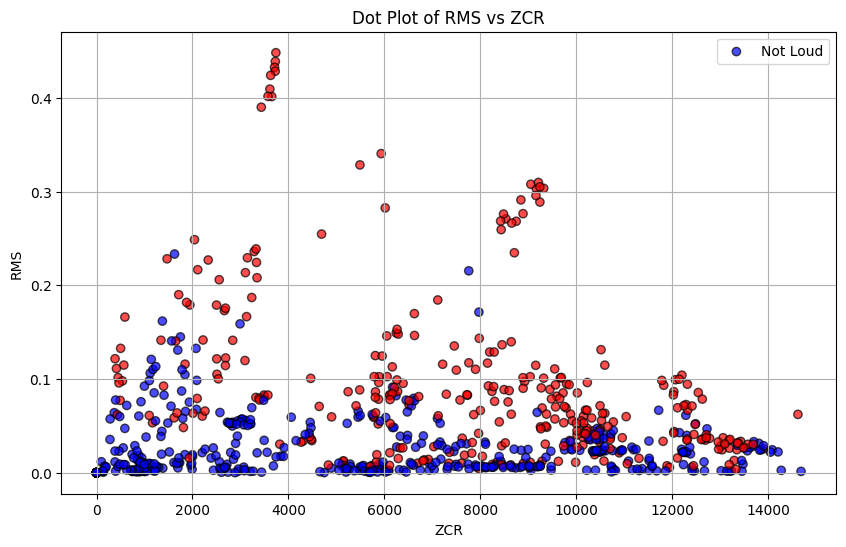

In [14]:
colors = df_raw['label'].map({2: 'blue', 1: 'red'})

plt.figure(figsize=(10, 6))
plt.scatter(df_raw['zcr'], df_raw['rms'], c=colors, alpha=0.7, edgecolors='k')
plt.xlabel('ZCR')
plt.ylabel('RMS')
plt.title('Dot Plot of RMS vs ZCR')
plt.grid(True)
plt.legend(labels=['Not Loud', 'Loud'])
plt.show()

Hyperparameters


In [ ]:
RMS_LOW_C = 0.0168545
RMS_LOW_S = 296.65667922513273

RMS_MEDIUM_M = 0.048329
RMS_MEDIUM_S = 0.036058598726114645

RMS_HIGH_C = 0.229253
RMS_HIGH_S = 22.827402013376858


ZCR_INFREQ_C = 4614.5
ZCR_INFREQ_S = 0.0010835410120273053

ZCR_MODERATE_M = 6150.125
ZCR_MODERATE_S = 4031.5286624203823

ZCR_FREQ_C = 10328.875
ZCR_FREQ_S = 0.0011462303349858154


LOUD_C = 0.8
LOUD_S = 25.0

NOT_LOUD_C = 0.2
NOT_LOUD_S = 25.0

# Fuzzy dan Fungsi


Membership Functions


In [ ]:
# Sigmoid membership function
def sigmf(x, c, s):
    return 1 / (1 + np.exp(-s * (x - c)))

# Gaussian membership function
def gaussmf(x, mean, sigma):
    return np.exp(-0.5 * ((x - mean) / sigma) ** 2)

Fuzzy Sets


In [ ]:
def fuzzify_rms(val):
    return {
        'low': sigmf(val, RMS_LOW_C, RMS_LOW_S),
        'medium': gaussmf(val, RMS_MEDIUM_M, RMS_MEDIUM_S),
        'high': sigmf(val, RMS_HIGH_C, RMS_HIGH_S)
    }

def fuzzify_zcr(val):
    return {
        'infrequent': sigmf(val, ZCR_INFREQ_C, ZCR_INFREQ_S),
        'moderate': gaussmf(val, ZCR_MODERATE_M, ZCR_MODERATE_S),
        'frequent': sigmf(val, ZCR_FREQ_C, ZCR_FREQ_S)
    }

## Fuzzy Inference System


### Mamdani Inference Engine


In [ ]:
def mamdani_rule_evaluation(rms_set, zcr_set):
    return [
        ('not_loud', min(rms_set['low'], zcr_set['infrequent'])),
        ('not_loud', min(rms_set['low'], zcr_set['moderate'])),
        ('not_loud', min(rms_set['low'], zcr_set['frequent'])),
        ('not_loud', min(rms_set['medium'], zcr_set['infrequent'])),
        ('not_loud', min(rms_set['medium'], zcr_set['moderate'])),
        ('loud', min(rms_set['medium'], zcr_set['frequent'])),
        ('loud', min(rms_set['high'], zcr_set['infrequent'])),
        ('loud', min(rms_set['high'], zcr_set['moderate'])),
        ('loud', min(rms_set['high'], zcr_set['frequent']))
    ]

def mamdani_aggregate(rules):
    loud_dom = [s for l, s in rules if l == 'loud']
    not_loud_dom = [s for l, s in rules if l == 'not_loud']
    return max(loud_dom) if loud_dom else 0, max(not_loud_dom) if not_loud_dom else 0

def mamdani_defuzzify(loud, not_loud):
    output_range = np.linspace(0, 1, 101)
    numerator = 0
    denominator = 0
    for o in output_range:
        mu = max(
            min(sigmf(o, LOUD_C, LOUD_S), loud),
            min(sigmf(o, NOT_LOUD_C, NOT_LOUD_S), not_loud)
        )
        numerator += o * mu
        denominator += mu
    return numerator / denominator if denominator != 0 else 0

def fuzzy_mamdani_infer(rms_val, zcr_val):
    rms_set = fuzzify_rms(rms_val)
    zcr_set = fuzzify_zcr(zcr_val)
    rules = mamdani_rule_evaluation(rms_set, zcr_set)
    loud, not_loud = mamdani_aggregate(rules)
    return mamdani_defuzzify(loud, not_loud)

### Sugeno Inference Engine


In [ ]:
def sugeno_rule_evaluation(rms_set, zcr_set):
    return [
        (min(rms_set['low'], zcr_set['infrequent']), 0.0),
        (min(rms_set['low'], zcr_set['moderate']), 0.0),
        (min(rms_set['low'], zcr_set['frequent']), 0.0),
        (min(rms_set['medium'], zcr_set['infrequent']), 0.0),
        (min(rms_set['medium'], zcr_set['moderate']), 0.0),
        (min(rms_set['medium'], zcr_set['frequent']), 1.0),
        (min(rms_set['high'], zcr_set['infrequent']), 1.0),
        (min(rms_set['high'], zcr_set['moderate']), 1.0),
        (min(rms_set['high'], zcr_set['frequent']), 1.0)
    ]

def sugeno_weighted_average(rules):
    numerator = sum(w * z for w, z in rules)
    denominator = sum(w for w, _ in rules)
    return numerator / denominator if denominator != 0 else 0

def fuzzy_sugeno_infer(rms_val, zcr_val):
    rms_set = fuzzify_rms(rms_val)
    zcr_set = fuzzify_zcr(zcr_val)
    rules = sugeno_rule_evaluation(rms_set, zcr_set)
    return sugeno_weighted_average(rules)

## Classification


In [ ]:
def classify_output(output):
    return 1 if output >= 0.5 else 2

def classify_mamdani(rms_val, zcr_val):
    output = fuzzy_mamdani_infer(rms_val, zcr_val)
    return classify_output(output)

def classify_sugeno(rms_val, zcr_val):
    output = fuzzy_sugeno_infer(rms_val, zcr_val)
    return classify_output(output)

# Example


Label 1 (Suara Keras)


In [ ]:
rms_val = 0.07
zcr_val = 9000

print(classify_mamdani(rms_val, zcr_val))
print(classify_sugeno(rms_val, zcr_val))

1
2


Label 2 (Suara Background)


In [ ]:
rms_val = 0.7
zcr_val = 9000

print(classify_mamdani(rms_val, zcr_val))
print(classify_sugeno(rms_val, zcr_val))

1
1


# Inference


In [ ]:
# Inference
y_mamdani = []
y_sugeno = []

for (rms, zcr) in X:
    y_mamdani.append(classify_mamdani(rms, zcr))
    y_sugeno.append(classify_sugeno(rms, zcr))

# Evaluate
print("Mamdani")
print(f"Accuracy: {accuracy_score(y, y_mamdani)}")
print(f"Precision: {precision_score(y, y_mamdani)}")
print(f"Recall: {recall_score(y, y_mamdani)}")
print(f"F1-Score: {f1_score(y, y_mamdani)}")
print(f"Confusion Matrix:\n {confusion_matrix(y, y_mamdani)}")

print("\nSugeno")
print(f"Accuracy: {accuracy_score(y, y_sugeno)}")
print(f"Precision: {precision_score(y, y_sugeno)}")
print(f"Recall: {recall_score(y, y_sugeno)}")
print(f"F1-Score: {f1_score(y, y_sugeno)}")
print(f"Confusion Matrix:\n {confusion_matrix(y, y_sugeno)}")

Mamdani
Accuracy: 0.6897856242118537
Precision: 0.6897856242118537
Recall: 1.0
F1-Score: 0.8164179104477612
Confusion Matrix:
 [[547   0]
 [246   0]]

Sugeno
Accuracy: 0.32156368221941994
Precision: 1.0
Recall: 0.016453382084095063
F1-Score: 0.03237410071942446
Confusion Matrix:
 [[  9 538]
 [  0 246]]


# Optuna


In [48]:
def optimize_fuzzy(trial):
    RMS_LOW_C = trial.suggest_float("RMS_LOW_C", -0.8, 0.0, step=0.001)
    RMS_LOW_S = trial.suggest_float("RMS_LOW_S", 0, 3.0, step=0.01)

    RMS_MEDIUM_M = trial.suggest_float("RMS_MEDIUM_M", 0.1, 1.0, step=0.001)
    RMS_MEDIUM_S = trial.suggest_float("RMS_MEDIUM_S", 0, 3.0, step=0.01)

    RMS_HIGH_C = trial.suggest_float("RMS_HIGH_C", 1.1, 2.0, step = 0.001)
    RMS_HIGH_S = trial.suggest_float("RMS_HIGH_S", 0, 3.0, step=0.01)

    ZCR_INFREQ_C = trial.suggest_float("ZCR_INFREQ_C", -1.6, -0.4)
    ZCR_INFREQ_S = trial.suggest_float("ZCR_INFREQ_S", 0, 3.0, step=0.01)

    ZCR_MODERATE_M = trial.suggest_float("ZCR_MODERATE_M", -0.3, 0.8)
    ZCR_MODERATE_S = trial.suggest_float("ZCR_MODERATE_S", 0, 3.0, step=0.01)

    ZCR_FREQ_C = trial.suggest_float("ZCR_FREQ_C", 0.9, 2.0)
    ZCR_FREQ_S = trial.suggest_float("ZCR_FREQ_S", 0, 3.0, step=0.01)

    LOUD_C = trial.suggest_float("LOUD_C", 0.0, 49.0, step=1.0)
    LOUD_S = trial.suggest_float("LOUD_S", 0, 3.0, step=0.01)

    NOT_LOUD_C = trial.suggest_float("NOT_LOUD_C", 50.0, 100.0, step=1.0)
    NOT_LOUD_S = trial.suggest_float("NOT_LOUD_S", 0, 3.0, step=0.01)

    def sigmf(x, c, s):
        return 1 / (1 + math.exp(-s * (x - c)))

    def gaussmf(x, m, s):
        return math.exp(-((x - m) ** 2) / (2 * s ** 2))

    def fuzzify_rms(val):
        return {
            'low': sigmf(val, RMS_LOW_C, RMS_LOW_S),
            'medium': gaussmf(val, RMS_MEDIUM_M, RMS_MEDIUM_S),
            'high': sigmf(val, RMS_HIGH_C, RMS_HIGH_S)
        }

    def fuzzify_zcr(val):
        return {
            'infrequent': sigmf(val, ZCR_INFREQ_C, ZCR_INFREQ_S),
            'moderate': gaussmf(val, ZCR_MODERATE_M, ZCR_MODERATE_S),
            'frequent': sigmf(val, ZCR_FREQ_C, ZCR_FREQ_S)
        }

    def mamdani_rule_evaluation(rms_set, zcr_set):
        return [
            ('not_loud', min(rms_set['low'], zcr_set['infrequent'])),
            ('not_loud', min(rms_set['low'], zcr_set['moderate'])),
            ('not_loud', min(rms_set['low'], zcr_set['frequent'])),
            ('not_loud', min(rms_set['medium'], zcr_set['infrequent'])),
            ('not_loud', min(rms_set['medium'], zcr_set['moderate'])),
            ('loud', min(rms_set['medium'], zcr_set['frequent'])),
            ('loud', min(rms_set['high'], zcr_set['infrequent'])),
            ('loud', min(rms_set['high'], zcr_set['moderate'])),
            ('loud', min(rms_set['high'], zcr_set['frequent']))
        ]

    def mamdani_aggregate(rules):
        loud_dom = [s for l, s in rules if l == 'loud']
        not_loud_dom = [s for l, s in rules if l == 'not_loud']
        return max(loud_dom) if loud_dom else 0, max(not_loud_dom) if not_loud_dom else 0

    def mamdani_defuzzify(loud, not_loud):
        output_range = np.linspace(0, 1, 101)
        numerator = 0
        denominator = 0
        for o in output_range:
            mu = max(
                min(sigmf(o, LOUD_C, LOUD_S), loud),
                min(sigmf(o, NOT_LOUD_C, NOT_LOUD_S), not_loud)
            )
            numerator += o * mu
            denominator += mu
        return numerator / denominator if denominator != 0 else 0

    def fuzzy_mamdani_infer(rms_val, zcr_val):
        rms_set = fuzzify_rms(rms_val)
        zcr_set = fuzzify_zcr(zcr_val)
        rules = mamdani_rule_evaluation(rms_set, zcr_set)
        loud, not_loud = mamdani_aggregate(rules)
        return mamdani_defuzzify(loud, not_loud)

    def classify_output(output):
        return 1 if output >= 0.5 else 2

    def classify_mamdani(rms_val, zcr_val):
        output = fuzzy_mamdani_infer(rms_val, zcr_val)
        return classify_output(output)

    y_mamdani = [classify_mamdani(rms, zcr) for rms, zcr in X]
    score = f1_score(y, y_mamdani)
    return score

In [ ]:
# [I 2025-05-15 10:29:42,686] Trial 440 finished with value: 0.8330733229329174 and parameters: {'RMS_LOW_C': 0.021385268838932454, 'RMS_LOW_S': 170.58823145759033, 'RMS_MEDIUM_M': 0.046375479902471636, 'RMS_MEDIUM_S': 0.00501027974247247, 'RMS_HIGH_C': 0.2753180384748499, 'RMS_HIGH_S': 12.002275095623094, 'ZCR_INFREQ_C': 2493.1656190114886, 'ZCR_INFREQ_S': 0.0008620631418804517, 'ZCR_MODERATE_M': 4782.852668951398, 'ZCR_MODERATE_S': 4757.887314646938, 'ZCR_FREQ_C': 14748.051615194798, 'ZCR_FREQ_S': 0.004670963030780051, 'LOUD_C': 0.9335071916290064, 'LOUD_S': 42.770147326791694, 'NOT_LOUD_C': 0.1901805921119046, 'NOT_LOUD_S': 11.826406346881223}. Best is trial 440 with value: 0.8330733229329174.

In [49]:
study = optuna.create_study(direction="maximize")
study.optimize(optimize_fuzzy, n_trials=5000)

print("Best F1 Score:", study.best_value)
print("Best Parameters:", study.best_params)

[I 2025-05-16 09:28:30,186] A new study created in memory with name: no-name-a9056947-77a8-4010-afa0-fd25ad57468f
[I 2025-05-16 09:28:30,526] Trial 0 finished with value: 0.5902222222222222 and parameters: {'RMS_LOW_C': -0.40800000000000003, 'RMS_LOW_S': 2.22, 'RMS_MEDIUM_M': 0.607, 'RMS_MEDIUM_S': 2.02, 'RMS_HIGH_C': 1.936, 'RMS_HIGH_S': 1.01, 'ZCR_INFREQ_C': -0.679356335230055, 'ZCR_INFREQ_S': 1.47, 'ZCR_MODERATE_M': 0.2705664488411013, 'ZCR_MODERATE_S': 1.34, 'ZCR_FREQ_C': 1.4514022216490092, 'ZCR_FREQ_S': 0.67, 'LOUD_C': 24.0, 'LOUD_S': 1.58, 'NOT_LOUD_C': 71.0, 'NOT_LOUD_S': 0.5700000000000001}. Best is trial 0 with value: 0.5902222222222222.
[I 2025-05-16 09:28:30,871] Trial 1 finished with value: 0.5902222222222222 and parameters: {'RMS_LOW_C': -0.22699999999999998, 'RMS_LOW_S': 2.84, 'RMS_MEDIUM_M': 0.5790000000000001, 'RMS_MEDIUM_S': 0.98, 'RMS_HIGH_C': 1.397, 'RMS_HIGH_S': 1.78, 'ZCR_INFREQ_C': -1.4683742229892192, 'ZCR_INFREQ_S': 0.44, 'ZCR_MODERATE_M': 0.21348346673131552, 

KeyboardInterrupt: 

# Visualize Fuzzy Function


In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Sigmoid membership function
def sigmf(x, c, s):
    return 1 / (1 + np.exp(-s * (x - c)))

# Gaussian membership function
def gaussmf(x, mean, sigma):
    return np.exp(-0.5 * ((x - mean) / sigma) ** 2)

def fuzzify_rms(val):
    return {
        'low': sigmf(val, RMS_LOW_C, RMS_LOW_S),
        'medium': gaussmf(val, RMS_MEDIUM_M, RMS_MEDIUM_S),
        'high': sigmf(val, RMS_HIGH_C, RMS_HIGH_S)
    }

def fuzzify_zcr(val):
    return {
        'infrequent': sigmf(val, ZCR_INFREQ_C, ZCR_INFREQ_S),
        'moderate': gaussmf(val, ZCR_MODERATE_M, ZCR_MODERATE_S),
        'frequent': sigmf(val, ZCR_FREQ_C, ZCR_FREQ_S)
    }

In [44]:
# RMS Membership Functions
RMS_LOW_C = -0.2
RMS_LOW_S = 2.5

RMS_MEDIUM_M = 0.5
RMS_MEDIUM_S = 0.8

RMS_HIGH_C = 1.5
RMS_HIGH_S = 2.0

# ZCR Membership Functions
ZCR_INFREQ_C = -0.5
ZCR_INFREQ_S = 2.0

ZCR_MODERATE_M = 0.0
ZCR_MODERATE_S = 0.8

ZCR_FREQ_C = 1.2
ZCR_FREQ_S = 2.0

# Loudness Membership Functions
LOUD_C = 0.7
LOUD_S = 10.0

NOT_LOUD_C = 0.3
NOT_LOUD_S = 10.0

x_axis = np.linspace(0, 1, 1000)

# Membership functions
low = sigmf(x_axis, RMS_LOW_C, RMS_LOW_S)
medium = gaussmf(x_axis, RMS_MEDIUM_M, RMS_MEDIUM_S)
high = sigmf(x_axis, RMS_HIGH_C, RMS_HIGH_S)

infrequent = sigmf(x_axis, ZCR_INFREQ_C, ZCR_INFREQ_S)
moderate = gaussmf(x_axis, ZCR_MODERATE_M, ZCR_MODERATE_S)
frequent = sigmf(x_axis, ZCR_FREQ_C, ZCR_FREQ_S)

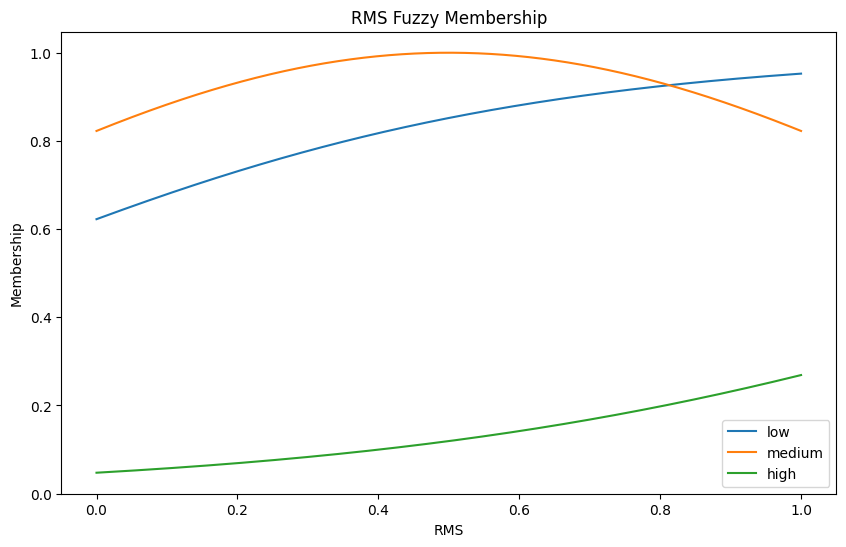

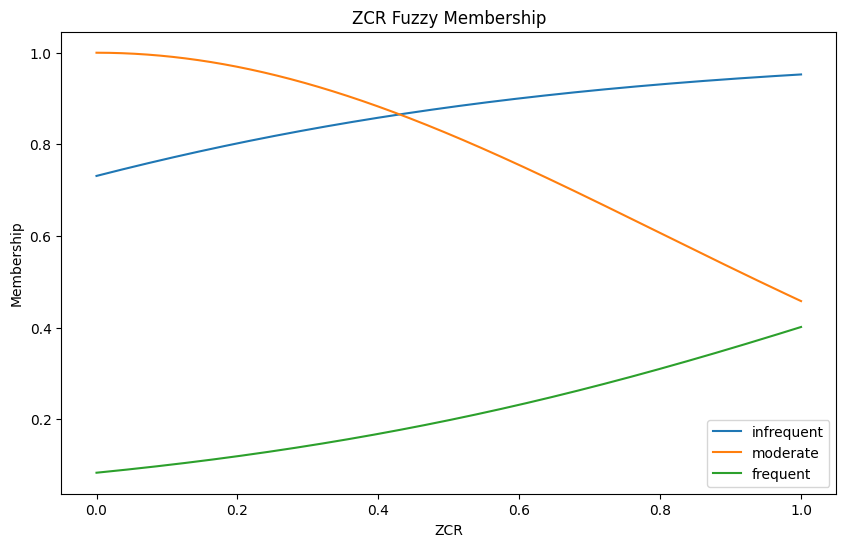

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(x_axis, low, label='low')
plt.plot(x_axis, medium, label='medium')
plt.plot(x_axis, high, label='high')
plt.xlabel('RMS')
plt.ylabel('Membership')
plt.title('RMS Fuzzy Membership')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x_axis, infrequent, label='infrequent')
plt.plot(x_axis, moderate, label='moderate')
plt.plot(x_axis, frequent, label='frequent')
plt.xlabel('ZCR')
plt.ylabel('Membership')
plt.title('ZCR Fuzzy Membership')
plt.legend()
plt.show()